100%|██████████| 500/500 [01:05<00:00,  7.64it/s]


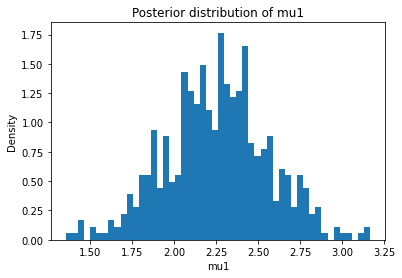

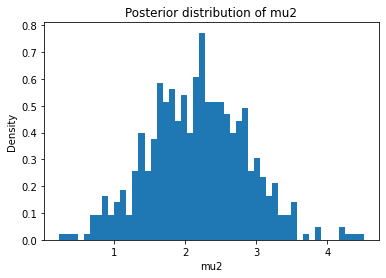

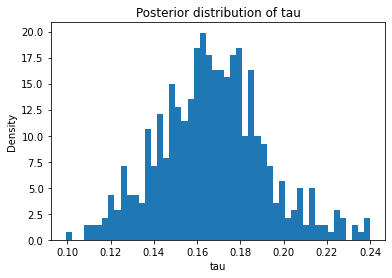

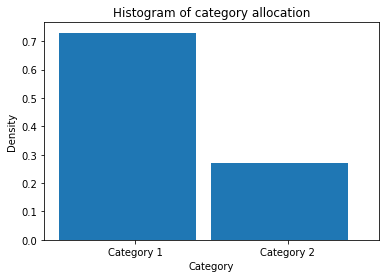

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set the hyperparameters and initial values

alpha = 1 # parameters for gamma distribution
beta = 1
xi = 2 # ξ is the mean of the prior distribution of mu1 and mu2
psi = 1 #precision of the normal distribution
w1 = np.random.beta(alpha, beta) #prior probability of observing category 1
w2 = 1 - w1 #prior probability of observing category 2
mu1 = np.random.normal(xi, 1/np.sqrt(psi)) #generate random somple mu1 from normal distribution with xi and psi
mu2 = np.random.normal(xi, 1/np.sqrt(psi)) #generate random somple mu2 from normal distribution with xi and psi
tau = np.random.gamma(alpha, 1/beta) #generate random somple from gamma distribution with alpha and beta
N = 100 # number of observations
n1 = int(w1 * N) #number of observations for category 1, rounded to nearest interger
n2 = N - n1 #remaining number of observations, this ensure number of observations in each category is proportional to the prior probability
w = np.concatenate([np.random.normal(mu1, 1/np.sqrt(tau), n1),
                    np.random.normal(mu2, 1/np.sqrt(tau), n2)]) # generate N observations from two normal distributions with means mu1 and mu2,
                                                #and precision tau, where the number of observations for each distribution is proportional to w1 and w2, respectively
num_samples = 500 #numbers of samples
s = np.random.choice([1, 2], size=N, p=[w1, w2]) # initial allocation of the observations to one of the two categories based on the prior probabilities w1 and w2
#initialize empty lists to store the samples for tau, mu1, mu2 and w1
tau_samples = [0] * num_samples
mu1_samples = [0] * num_samples
mu2_samples = [0] * num_samples
w1_samples = [0] * num_samples
# Define the likelihood function using normal pdf with mean mu and precision at value x
def likelihood(x, mu, tau):
    return stats.norm(mu, 1/np.sqrt(tau)).pdf(x)
# return the prior probability of observing the value s, which is either 1 or 2
def prior_s(s, w1, w2):
    if s == 1:
        return w1
    elif s == 2:
        return w2
# Define the Gibbs sampler
for i in tqdm(range(num_samples)): #loop num_samples time
    # Sample tau from the posterior distribution
    alpha_new = alpha + N/2 #new value of alpha is the old alpha + half of number of observations
    beta_new = beta + np.sum((s == 1) * (w - mu1)**2) + np.sum((s == 2) * (w - mu2)**2) #calculated using sum of squared different between w and correspond mu for
                                                            #each group, s can only take on values of 1 or 2 (boolean indexing)
    tau = np.random.gamma(alpha_new, 1/beta_new) # generate tau new by sampling from gamma distribution with alpha_new and beta_new
    tau_samples[i] = tau #update value of tau
    # Sample mu1 from the posterior distribution
    precision = tau * np.sum(s == 1) # multiplying tau with total number of observations in group 1
    mean = (xi/psi + np.sum(w[s == 1])) / (1/psi + np.sum(s == 1)) # calculated the posterior mean of the normal distribution of the observation in group 1,
                                                                # xi/psi is the prior mean
    mu1 = np.random.normal(mean, 1/np.sqrt(precision))
    mu1_samples[i] = mu1
    # Sample mu2 from the posterior distribution
    precision = tau * np.sum(s == 2)
    mean = (xi/psi + np.sum(w[s == 2])) / (1/psi + np.sum(s == 2))
    mu2 = np.random.normal(mean, 1/np.sqrt(precision))
    mu2_samples[i] = mu2
    # Sample s from the posterior distribution
    for j in range(N):
        prob_s1 = likelihood(w[j], mu1, tau) * prior_s(1, w1, w2)
        prob_s2 = likelihood(w[j], mu2, tau) * prior_s(2, w1, w2)
        s[j] = np.random.choice([1, 2], p=[prob_s1/(prob_s1 + prob_s2), prob_s2/(prob_s1 + prob_s2)])
    # Sample w1 from the posterior distribution
    alpha_w1 = w1_samples[i] + np.sum(s == 1)
    beta_w1 = 1 - w1_samples[i] + np.sum(s == 2)
    w1 = np.random.beta(alpha_w1, beta_w1)
    w1_samples[i] = w1 if i < num_samples-1 else np.zeros(num_samples)
    # Store the samples for mu1, mu2, and tau
    mu1_samples.append(mu1)
    mu2_samples.append(mu2)
    tau_samples.append(tau)
    w1_samples.append(w1)
# Plot the posterior distribution of mu1
plt.figure()
plt.hist(mu1_samples, bins=50, density=True)
plt.title('Posterior distribution of mu1')
plt.xlabel('mu1')
plt.ylabel('Density')
plt.show()
# Plot the posterior distribution of mu2
plt.figure()
plt.hist(mu2_samples, bins=50, density=True)
plt.title('Posterior distribution of mu2')
plt.xlabel('mu2')
plt.ylabel('Density')
plt.show()
# Plot the posterior distribution of tau
plt.figure()
plt.hist(tau_samples, bins=50, density=True)
plt.title('Posterior distribution of tau')
plt.xlabel('tau')
plt.ylabel('Density')
plt.show()
# Plot the posterior distribution of sn
plt.hist(s, bins=[0.5, 1.5, 2.5], width=0.9, density= True)
plt.xticks([1, 2], ['Category 1', 'Category 2'])
plt.xlabel('Category')
plt.ylabel('Density')
plt.title('Histogram of category allocation')
plt.show()